In [118]:
# Please install openpyxl and odfpy from pip or anaconda in order to import the inout data files
# import sys
# !{sys.executable} -m pip install openpyxl
# !{sys.executable} -m pip install odfpy

# Import libraries and set plot styles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sc
import statsmodels.graphics.gofplots as sm
from sklearn.linear_model import LinearRegression

# Show plots inline
%matplotlib inline

# Set plot style
# plot.style.available
plt.style.use('fivethirtyeight')

In [176]:
# Read in and preview data
df = pd.read_csv('/Users/FM/Public/HDS/Summer Project/Real/agg_data_inner_11_cis_mar22.csv',
                 parse_dates=['date'],
                 dayfirst=True)
df1 = pd.read_excel('/Users/FM/Public/HDS/Summer Project/Real/Region Mapping.xlsx')
df2 = pd.read_excel('/Users/FM/Public/HDS/Summer Project/R_and_growth_rate_time_series_for_publication_v1.0.ods',
                    sheet_name=2,
                    engine='odf',
                    header=[7,8], #Two rows of header
                    na_values='.'
                    )

# Select header titles and data range
df1.columns = df1.iloc[2]
region_map = df1.iloc[3:, :]
r_val = df2.iloc[:, 1:]

# Merge 2 header rows
r_val.columns = ['_'.join(header).upper() for header in r_val.columns]

# Rename specific columns for joining
df.rename(columns={'cis20cd': 'CIS20CD'}, inplace=True)
df.rename(columns={'grab_compo_boo': 'compo_frac'}, inplace=True)
region_map.rename(columns={'Geography Code': 'CIS20CD'}, inplace=True)

# Remove missing values
r_val = r_val.dropna()

### Copied from UKHSA code ###
# Variable labels that are not changed
variable_labels = {
    'sars_cov2_gc_l_mean': 'SARS-CoV-2 concentration',
    'sample_ph_pre_ansis':'sample pH',
    'ammonia_mg_l':'ammonia concentration',
    #'control_gc_l_mean':'control volume',
    'ophosph_mg_l':'phosphate concentration',
    'suspended_solids_mg_l':'suspended solids',
    'sars_below_loq':'below LOQ',
    'sars_below_lod':'below LOD',
    'compo_frac':'composites fraction',
    'reception_delay':'reception delay',
    'catch_cis_population':'covered population',
    'catch_in_cis_prop':'subregion population fraction',
    "catchment_population_ons_mid_2019": "catchment population",
    "catchment_area": 'catchment area'
}

/var/folders/st/76qg2qy17gx68wvlkq_41fkw0000gn/T/ipykernel_77094/3625172548.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_map.rename(columns={'Geography Code': 'CIS20CD'}, inplace=True)


In [120]:
# df.head()
# region_map.head()
# r_val. head()

In [ ]:
r_val['average'] = r_val[['F7','F8']].mean(axis=1)

In [79]:
# Match region to codes in wastewater data
model_dataset = pd.merge(df, region_map[['CIS20CD', 'Country', 'Region']], on='CIS20CD', how='left')

# Match with R values
model_dataset2 = pd.merge(model_dataset, df2, on='')

In [81]:
# Dimension of dataframe
model_dataset.shape

# Number of unique sites
model_dataset.CIS20CD.nunique()

# Convert datatypes and set factors
model_dataset['date'] = [pd.to_datetime(d) for d in model_dataset['date']]
model_dataset.describe()

# Date range
print('Study period from', model_dataset.date.min(), 'to', model_dataset.date.max())

Study period from 2020-09-04 00:00:00 to 2021-02-10 00:00:00


In [93]:
model_dataset.head()

,Unnamed: 0,CIS20CD,date,sars_cov2_gc_l_mean,suspended_solids_mg_l,ammonia_mg_l,ophosph_mg_l,sample_ph_pre_ansis,control_gc_l_mean,reac_vol_control,...,reception_delay,catchment_population_ons_mid_2019,catchment_area,catch_in_cis_prop,catch_cis_population,median_prob,ll,ul,Country,Region
0,0,J06000104,2020-09-04,411.600257,74.0,27.0,3.3,7.4,22729300.0,2.0,...,23.566667,58579.0,75.718339,0.190042,58576.83105,0.163286,0.099304,0.268339,England,North East
1,1,J06000104,2020-09-06,10322.565430,220.0,36.0,4.2,7.4,22729300.0,2.0,...,20.883333,58579.0,75.718339,0.190042,58576.83105,0.187147,0.116679,0.299341,England,North East
2,2,J06000104,2020-09-07,1641.482698,260.0,32.0,4.1,7.4,22729300.0,2.0,...,23.400000,58579.0,75.718339,0.190042,58576.83105,0.199078,0.125366,0.314841,England,North East
3,3,J06000104,2020-09-09,66.500000,650.0,33.0,4.2,7.4,22729300.0,2.0,...,23.783333,58579.0,75.718339,0.190042,58576.83105,0.222940,0.142741,0.345843,England,North East
4,4,J06000104,2020-09-11,608.080049,230.0,36.0,4.5,7.4,22729300.0,2.0,...,23.616667,58579.0,75.718339,0.190042,58576.83105,0.253649,0.165762,0.385488,England,North East


In [82]:
subset = model_dataset[['CIS20CD', 'date', 'sars_cov2_gc_l_mean', 'catchment_population_ons_mid_2019']]

In [83]:
# Set index as date to perform interpolation
subset.index = subset['date']
del subset['date']

# Linear interpolation
daily_interpol = subset.groupby(['CIS20CD']).resample('D').mean()
daily_interpol['sars_cov2_gc_l_mean']=daily_interpol['sars_cov2_gc_l_mean'].interpolate()

# Reset index of date and sitecode
daily_interpol = daily_interpol.reset_index()

# Rolling average in a new column called mean_gene??
subset2 = daily_interpol.assign(mean_gene = daily_interpol['sars_cov2_gc_l_mean'].rolling(window=7).mean())

# log-transformation
subset2['log_gene'] = np.log10(subset2['mean_gene'])

In [84]:
# Check data types of each column
subset2.dtypes

CIS20CD                                      object
date                                 datetime64[ns]
sars_cov2_gc_l_mean                         float64
catchment_population_ons_mid_2019           float64
mean_gene                                   float64
log_gene                                    float64
dtype: object

Text(0.5, 1.0, 'Log RNA level Over Time')

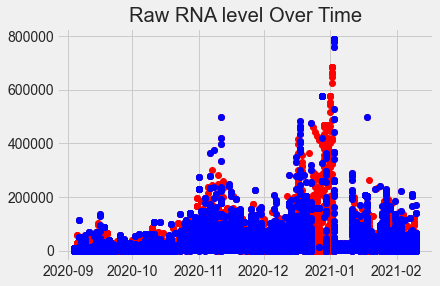

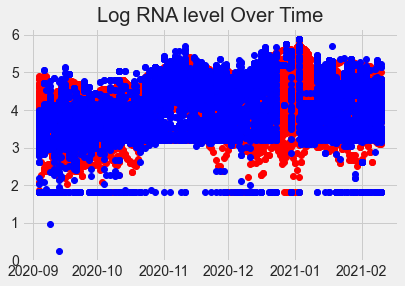

In [85]:
# EDA plots to compare before and after interpolation
# Red = after interpolation

# Raw RNA level over time
plt.plot_date(subset2['date'], subset2['sars_cov2_gc_l_mean'], c = 'red')
plt.plot_date(df['date'], df['sars_cov2_gc_l_mean'], c = 'blue')
plt.title('Raw RNA level Over Time')

# Log RNA level over time
plt.figure()
plt.plot_date(subset2['date'], subset2['log_gene'], c = 'red')
plt.plot_date(df['date'], np.log10(df['sars_cov2_gc_l_mean']), c = 'blue')
plt.title('Log RNA level Over Time')


In [33]:
# Check number of values under each site
# subset2.CIS20CD.value_counts() #160 counts for site

# Check number of zero values
# (subset2 == 0).sum()

J06000104    160
J06000184    160
J06000182    160
J06000181    160
J06000180    160
            ... 
J06000144    160
J06000141    160
J06000140    160
J06000159    158
J06000162    158
Name: CIS20CD, Length: 83, dtype: int64

In [98]:
sample_variables = ['sars_cov2_gc_l_mean',
                    'suspended_solids_mg_l', 'ammonia_mg_l', 'ophosph_mg_l',
                    'sample_ph_pre_ansis',
                    'control_gc_l_mean','reac_vol_control', # "reac_vol_sars",
                    # 'raw_ansis_sars_repc_1', 'raw_ansis_sars_repc_2',
                    # 'raw_ansis_sars_repc_mean',
                    'raw_ansis_sars_repc_std',
                    'compo_frac',
                    'sars_below_lod', 'sars_below_loq',
                    'reception_delay',
                    #                    'ww_site_code',  # try here?
                    #                     'date',
                    #                   'analysis_lab_code',
                    #'lab_analysis_1.1.1', 'lab_analysis_1.1.2',
                    #'target_gene_N1'
                    ]

site_variables = [
    'catchment_population_ons_mid_2019',
    'catchment_area'
    #                   ,'site_skey',  # numeric so should be ok.
    #                   'ww_site_code',
    #                   'water_company_AE',
    #                   'water_company_AW', 'water_company_NW', 'water_company_ST',
    #                   'water_company_SW', 'water_company_SWS', 'water_company_TW',
    #                   'water_company_UU', 'water_company_WW', 'water_company_WXW',
    #                   'water_company_YW'
                 ]

cis_variables = ['catch_in_cis_prop', 'catch_cis_population'
    #             ,'cis_population'
                 ]

all_variables = sample_variables + site_variables + cis_variables

In [99]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

dict_models = dict(lr = LinearRegression(),
                   xgb = XGBRegressor())

model_variables = dict(lr = all_variables,
                       xgb = all_variables)

model_labels = {'lr': 'Linear Regression','xgb': 'Gradient Boosted',
                'process': 'Process-based'}

In [100]:
# Bootstrap predictions
from ml_utils import bootstrap, Dataset

repeat = 50
preds_bootstrap = {}

models = ['lr', 'xgb'] # remove some models as desired, as RE can be long for example

for model_name in models:
    dataset = Dataset(model_dataset.set_index(['CIS20CD', 'date']), model_variables[model_name],
                      'median_prob', input_offset=0.001) #'median_prob' refers to prevalence still
    x, y = dataset.prepare_no_split()
    preds_bootstrap[model_name] = bootstrap(dict_models[model_name], x, y, repeat=repeat)

100%|██████████| 50/50 [00:18<00:00,  2.73it/s]


In [37]:
# Computing Mean and SE of errors

dict_pred = {model_name: preds_bootstrap[model_name].mean(1) for model_name in preds_bootstrap}
# dict_pred_natural = {model_name: 10**preds_bootstrap[model_name].mean(1) for model_name in preds_bootstrap}
dict_se = {model_name: pred.std(1)/np.sqrt(repeat - np.isnan(pred).sum(1)) for model_name, pred in preds_bootstrap.items()}
dict_se_natural = {model_name: 10**pred.std(1)/np.sqrt(repeat - np.isnan(pred).sum(1)) for model_name, pred in preds_bootstrap.items()}

mean absolute error 0.2231
median absolute error 0.1723
q95 absolute error 0.6030

Natural space
median relative error 37.9699
q95 relative error 235.3919
median absolute error 31.0944
q95 absolute error 140.1767


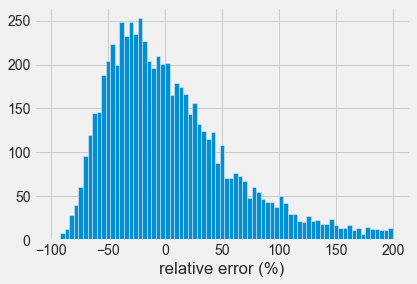

Text(0.5, 0, 'signed error (% infected)')

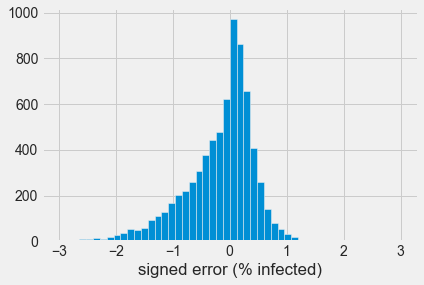

In [38]:
# Error for xgb

print(f'mean absolute error {np.abs((dict_pred[model_name]-y)).mean():.4f}')
print(f'median absolute error {np.abs((dict_pred[model_name]-y)).median():.4f}')
print(f'q95 absolute error {np.quantile(np.abs((dict_pred[model_name]-y)), 0.95):.4f}')

# Natural space
print('\nNatural space')
print(f'median relative error {np.abs((10**dict_pred[model_name]-10**y)/10**y).median()*100:.4f}')
print(f'q95 relative error {np.quantile(np.abs((10**dict_pred[model_name]-10**y)/10**y), 0.95)*100:.4f}')

print(f'median absolute error {np.abs((10**dict_pred[model_name]-10**y)).median()*100:.4f}')
print(f'q95 absolute error {np.quantile(np.abs((10**dict_pred[model_name]-10**y)), 0.95)*100:.4f}')

plt.hist((10**dict_pred[model_name]-10**y)/10**y*100, 75, range=(-100, 200))
plt.xlabel('relative error (%)')
plt.show()

plt.hist((10**dict_pred[model_name]-10**y), 50, range=(-3,3))
plt.xlabel('signed error (% infected)')